In [864]:
import pandas
import tensorflow

print(pandas.__version__)
print(tensorflow.__version__)

1.3.3
2.6.0


In [865]:
import datetime as dt
from pathlib import Path
import os
import time
from datetime import datetime
from IPython.display import display

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [866]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


# 데이터의 전처리

In [867]:
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

In [868]:
data.info

<bound method DataFrame.info of          UserId  ItemId  Rating       Time
31            1    3186       4  978300019
22            1    1270       5  978300055
27            1    1721       4  978300055
37            1    1022       5  978300055
24            1    2340       3  978300103
...         ...     ...     ...        ...
1000019    6040    2917       4  997454429
999988     6040    1921       4  997454464
1000172    6040    1784       3  997454464
1000167    6040     161       3  997454486
1000042    6040    1221       4  998315055

[1000209 rows x 4 columns]>

In [869]:
user_length = data.groupby('UserId').size()
user_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [870]:
user_length.median(), user_length.mean()

(96.0, 165.5975165562914)

In [871]:
user_length.min(), user_length.max()

(20, 2314)

In [872]:
user_length.quantile(0.999)

1343.181000000005

In [873]:
long_user = user_length[user_length==2314].index[0]
data[data['UserId']==long_user]

,UserId,ItemId,Rating,Time
696969,4169,1268,5,965333392
697168,4169,2617,4,965333392
697185,4169,2628,4,965333392
697219,4169,2653,4,965333392
697275,4169,423,3,965333392
...,...,...,...,...
697882,4169,3754,2,1024174347
695702,4169,1413,3,1024175031
697358,4169,494,4,1024175760
695945,4169,1804,2,1024175783


In [874]:
length_count = user_length.groupby(user_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

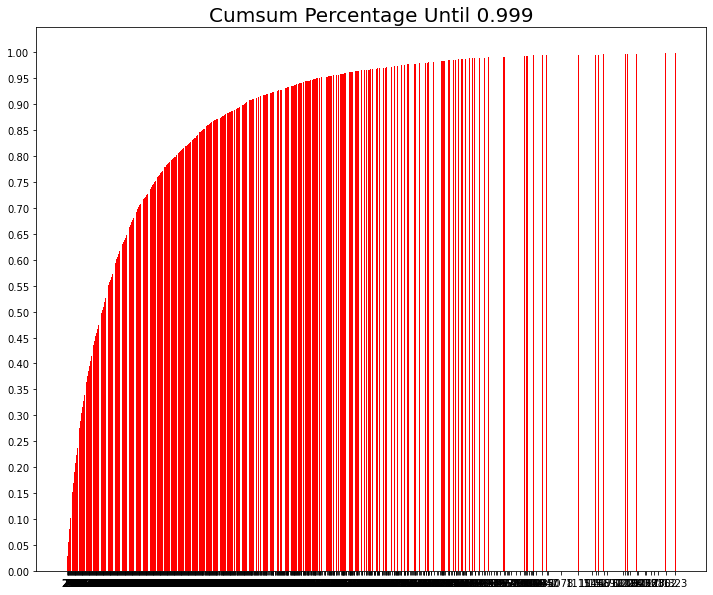

In [875]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

In [876]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

956703932
1046454590


In [877]:
type(latest)

numpy.int64

In [878]:
data['Time'] = pd.to_datetime(data['Time'], unit='s')

In [879]:
latest =  pd.to_datetime(latest, unit='s')

In [880]:
type(latest)

pandas._libs.tslibs.timestamps.Timestamp

In [881]:
month_ago = latest - dt.timedelta(90)     # 최종 날짜로부터 90일 이전 날짜를 구한다.  
data = data[data['Time'] > month_ago]   # 방금 구한 날짜 이후의 데이터만 모은다. 
#data = data[data['Rating']>1]
data

,UserId,ItemId,Rating,Time
5200,36,2269,5,2002-12-22 08:05:50
5256,36,1701,4,2002-12-22 08:05:50
5184,36,2694,3,2002-12-22 08:08:14
5364,36,3786,4,2002-12-22 08:08:41
5262,36,2369,4,2002-12-22 08:09:24
...,...,...,...,...
984731,5950,3948,4,2003-02-27 18:13:57
984682,5950,3578,4,2003-02-27 18:14:30
984475,5950,3793,3,2003-02-27 18:15:10
984660,5950,3555,2,2003-02-27 18:15:37


In [882]:
# ✅ 시간 기준 정렬 후 Train, Validation, Test 데이터 분할
data = data.sort_values(['UserId', 'Time']).reset_index(drop=True)

train_size = int(len(data) * 0.8)
val_size = int(len(data) * 0.1)

train = data.iloc[:train_size]
val = data.iloc[train_size: train_size + val_size]
test = data.iloc[train_size + val_size:]

print(f"✅ Train size: {len(train)}, Validation size: {len(val)}, Test size: {len(test)}")


✅ Train size: 3692, Validation size: 461, Test size: 463


In [883]:
# 1) Train에서 등장한 UserId 및 ItemId 목록 구하기
train_user_ids = train['UserId'].unique()
train_item_ids = train['ItemId'].unique()

# 2) Validation에서 Train에 없는 Item은 제외
val = val[val['ItemId'].isin(train_item_ids)]

# 3) Test에서도 일부 새로운 Item을 유지 (Train에 50% 이상 등장한 Item 유지)
test = test[(test['ItemId'].isin(train_item_ids)) | 
            (test['ItemId'].isin(test['ItemId'].value_counts().index[:int(len(test) * 0.5)]))]

# 4) Train에서 가장 많이 등장한 아이템을 선택 (Top-N 인기 아이템)
top_items = train['ItemId'].value_counts().index[:10].tolist()

# 5) Test 데이터에서 Train에 없는 UserId가 있다면, Top-N 인기 아이템을 제공
if len(test) > 0 and len(top_items) > 0:
    test.loc[test['ItemId'].isin(train_item_ids) == False, 'ItemId'] = np.random.choice(top_items, size=len(test[test['ItemId'].isin(train_item_ids) == False]))

# 6) Test 데이터가 비어있는 경우, Train 데이터에서 일부 샘플을 복사
if len(test) == 0:
    test = train.sample(n=int(len(train) * 0.1), random_state=42).copy()

print("✅ Train size:", len(train))
print("✅ Val size  :", len(val))
print("✅ Test size :", len(test))




✅ Train size: 3692
✅ Val size  : 382
✅ Test size : 420


In [884]:
train.head()

,UserId,ItemId,Rating,Time
0,36,2269,5,2002-12-22 08:05:50
1,36,1701,4,2002-12-22 08:05:50
2,36,2694,3,2002-12-22 08:08:14
3,36,3786,4,2002-12-22 08:08:41
4,36,2369,4,2002-12-22 08:09:24


In [885]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

train.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

# 모델 구성

In [886]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [887]:
# ✅ 전체 데이터에서 아이템 ID 인코딩 (0부터 시작하는 값으로 변환)
all_data = pd.concat([train, val, test], ignore_index=True)
all_data['ItemId_new'] = all_data['ItemId'].astype('category').cat.codes

# ✅ 고유 아이템 개수
num_items = all_data['ItemId_new'].nunique()
print("✅ 총 아이템 개수:", num_items)

# ✅ Train, Validation, Test로 다시 분할
train_mapped = all_data.iloc[:len(train)].copy()
val_mapped = all_data.iloc[len(train): len(train) + len(val)].copy()
test_mapped = all_data.iloc[len(train) + len(val):].copy()



✅ 총 아이템 개수: 1644


In [888]:
def prepare_data_with_rating(df, num_items):
    """
    데이터를 (X, Y) 형태로 변환하는 함수 (Rating 반영)
    - X: (N, 1, num_items) 크기의 원-핫 벡터 (입력 데이터)
    - Y: (N, num_items) 크기의 가중치 원-핫 벡터 (정답 데이터, Rating 반영)
    """
    N = len(df)
    X = np.zeros((N, 1, num_items), dtype=np.float32)  # (N, 1, num_items) 형태
    Y = np.zeros((N, num_items), dtype=np.float32)     # (N, num_items) 형태

    for i, row in enumerate(df.itertuples()):
        item_idx = row.ItemId_new
        rating = row.Rating / 5.0  # Rating을 0~1 범위로 정규화

        X[i, 0, item_idx] = 1.0  # X: 원-핫 벡터
        Y[i, item_idx] = rating  # Y: Rating 값 반영 (가중치)

    return X, Y

# ✅ `ItemId_new`를 사용하여 X, Y 데이터 만들기
train_X, train_Y = prepare_data_with_rating(train_mapped, num_items)
val_X, val_Y = prepare_data_with_rating(val_mapped, num_items)
test_X, test_Y = prepare_data_with_rating(test_mapped, num_items)

print(f"✅ train_X shape: {train_X.shape}, train_Y shape: {train_Y.shape}")
print(f"✅ val_X shape: {val_X.shape}, val_Y shape: {val_Y.shape}")
print(f"✅ test_X shape: {test_X.shape}, test_Y shape: {test_Y.shape}")


✅ train_X shape: (3692, 1, 1644), train_Y shape: (3692, 1644)
✅ val_X shape: (382, 1, 1644), val_Y shape: (382, 1644)
✅ test_X shape: (420, 1, 1644), test_Y shape: (420, 1644)


In [889]:
batch_size = min(2048, len(train_X))


def pad_to_batch_size(X, Y, batch_size):
    num_pad = batch_size - (len(X) % batch_size)
    if num_pad < batch_size:
        X = np.pad(X, ((0, num_pad), (0, 0), (0, 0)), mode='constant')
        Y = np.pad(Y, ((0, num_pad), (0, 0)), mode='constant')
    return X, Y

val_X, val_Y = pad_to_batch_size(val_X, val_Y, batch_size)
test_X, test_Y = pad_to_batch_size(test_X, test_Y, batch_size)


In [890]:
steps_per_epoch = max(1, len(train_X) // batch_size)


In [891]:
from tensorflow.keras.layers import Input, GRU, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# ✅ 모델 생성
inputs = Input(batch_shape=(None, 1, num_items))
gru_outputs, _ = GRU(50, return_state=True, name='GRU')(inputs)
dropout = Dropout(0.1)(gru_outputs)
predictions = Dense(num_items, activation='softmax')(dropout)

model = Model(inputs=inputs, outputs=predictions)

# ✅ BPR Loss 적용
def bpr_loss(y_true, y_pred):
    pos_scores = tf.reduce_sum(y_true * y_pred, axis=-1)
    neg_scores = tf.reduce_sum((1 - y_true) * y_pred, axis=-1)
    return -tf.reduce_mean(tf.math.log_sigmoid(pos_scores - neg_scores))

model.compile(loss=bpr_loss, optimizer=Adam(0.0001), metrics=['accuracy'])
model.summary()


Model: "model_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        [(None, 1, 1644)]         0         
_________________________________________________________________
GRU (GRU)                    [(None, 50), (None, 50)]  254400    
_________________________________________________________________
dropout_29 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_29 (Dense)             (None, 1644)              83844     
Total params: 338,244
Trainable params: 338,244
Non-trainable params: 0
_________________________________________________________________


In [892]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# ✅ 모델 학습
epochs = 20
batch_size = 128

model.fit(
    x=train_X,
    y=train_Y,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(val_X, val_Y),
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/20
29/29 [==============================] - 2s 17ms/step - loss: 1.3126 - accuracy: 0.0000e+00 - val_loss: 1.3131 - val_accuracy: 0.0000e+00
Epoch 2/20
29/29 [==============================] - 0s 6ms/step - loss: 1.3126 - accuracy: 0.0000e+00 - val_loss: 1.3131 - val_accuracy: 0.0000e+00
Epoch 3/20
29/29 [==============================] - 0s 6ms/step - loss: 1.3126 - accuracy: 0.0000e+00 - val_loss: 1.3131 - val_accuracy: 0.0000e+00
Epoch 4/20
29/29 [==============================] - 0s 6ms/step - loss: 1.3126 - accuracy: 0.0011 - val_loss: 1.3131 - val_accuracy: 4.8828e-04
Epoch 5/20
29/29 [==============================] - 0s 6ms/step - loss: 1.3126 - accuracy: 0.0019 - val_loss: 1.3131 - val_accuracy: 4.8828e-04
Epoch 6/20
29/29 [==============================] - 0s 6ms/step - loss: 1.3126 - accuracy: 0.0054 - val_loss: 1.3131 - val_accuracy: 9.7656e-04
Epoch 7/20
29/29 [==============================] - 0s 6ms/step - loss: 1.3126 - accuracy: 0.0081 - val_loss: 1.3131 - val_

In [893]:
print("\n=== Test Evaluation ===")
test_loss, test_acc = model.evaluate(test_X, test_Y, batch_size=batch_size, verbose=1)
print(f"[Test] Loss={test_loss:.4f}, Acc={test_acc:.4f}")



=== Test Evaluation ===
16/16 [==============================] - 0s 2ms/step - loss: 1.3131 - accuracy: 0.0337
[Test] Loss=1.3131, Acc=0.0337


In [894]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

In [895]:
# ✅ Recall@K 및 MRR@K 계산
k = 10
recall_scores = []
mrr_scores = []

for i in range(len(true_items)):
    pred_items = top_k_preds[i]
    true_item = true_items[i]

    recall_scores.append(recall_k(pred_items, true_item, k))
    mrr_scores.append(mrr_k(pred_items, true_item, k))

# ✅ 최종 평가 결과
recall_avg = np.mean(recall_scores)
mrr_avg = np.mean(mrr_scores)

print(f"✅ Recall@{k}: {recall_avg:.4f}")
print(f"✅ MRR@{k}: {mrr_avg:.4f}")



✅ Recall@10: 0.0444
✅ MRR@10: 0.0414


In [896]:
# ✅ 모델 예측 (Softmax 확률 출력)
y_pred = model.predict(test_X, batch_size=128)

# ✅ 추천 아이템 리스트 생성 (Top-K 추천)
k = 10
top_k_preds = np.argsort(-y_pred, axis=1)[:, :k]  # 확률이 높은 상위 K개 아이템 추출

# ✅ 실제 정답 아이템 리스트
true_items = np.argmax(test_Y, axis=1)  # 실제 정답 아이템 (one-hot -> index 변환)

print(y_pred)
print(top_k_preds)
print(true_items)

[[0.00061924 0.00060939 0.00060974 ... 0.00061009 0.00060809 0.00061674]
 [0.000621   0.00060442 0.00060785 ... 0.00060389 0.00060533 0.00061689]
 [0.00062092 0.00060774 0.00061626 ... 0.0006078  0.00060884 0.00061695]
 ...
 [0.00061973 0.00060902 0.00061339 ... 0.00060801 0.00060529 0.00061797]
 [0.00061973 0.00060902 0.00061339 ... 0.00060801 0.00060529 0.00061797]
 [0.00061973 0.00060902 0.00061339 ... 0.00060801 0.00060529 0.00061797]]
[[1236  800  110 ... 1639  679  498]
 [1236  403  280 ...  454 1579 1628]
 [1236  246 1579 ... 1628  943  433]
 ...
 [1236 1579  800 ... 1509  799  491]
 [1236 1579  800 ... 1509  799  491]
 [1236 1579  800 ... 1509  799  491]]
[ 800 1236  353 ...    0    0    0]
